## Problem set 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 2.2 Restricted three-body problem

In [2]:
from scipy import integrate

In [108]:
class ThreeBody:
    def __init__(self):
        self.G = 4 * np.pi**2 # (AU^3)*(m_s^-1)*(yr^−2) gravitational constant 
        # -- SUN --
        self.r0 = 0 #sun fixed in origin
        self.m0 = 1 #solar mass
        self.R_01 = 1 #AU sun–earth distance
        # -- EARTH --
        self.T1 = 1 #yr earth year
        self.m1 = 3*10**-6 #mass of earth
        # -- MOON --
        self.T2 = 27.3/365.3 #yr moon’s orbital period
        self.m2 = 3.69*10**-8 #mass of moon
        self.R_12 = 2.57*10**-3 #AU earth-moon distance
        
        self.energy = []
        self.angular = []
        self.time = []
        self.solution = None
        
    def __initial_conditions(self):
        r_00 = [0, 0]
        r_01 = [self.R_01, 0]
        r_02 = [self.R_01 + self.R_12, 0]

        v_00 = [0, 0]
        v_01 = [0, self.R_01*2*np.pi/self.T1]
        v_02 = [0, self.R_01*2*np.pi/self.T1 + self.R_12*2*np.pi/self.T2]

        return np.array(r_00 + r_01 + r_02 + v_00 + v_01 + v_02)
    
    def __force(self, ri, rj, mi, mj, mk):
        return -self.G*(mj*mi*(ri)/(np.linalg.norm(ri)**3)) - self.G*(mk*mi*(rj)/(np.linalg.norm(rj)**3))
    
    def __hamiltonian(self, r1, r2, p1, p2):
        r = [[0, 0], r1, r2]
        p = [[0, 0], p1, p2]
        m = [1, self.m1, self.m2]

        part1 = []
        for i in range(len(r)):
            part1.append(np.dot(p[i], p[i])/(2*m[i]))
            
        part2 = []
        for j in range(len(r)):
            for k in range(len(r)):
                if j < k:
                    part2.append((m[j]*m[k] / np.linalg.norm(r[j]-r[k]))*-self.G)
        return np.sum(part1) + np.sum(part2)
    
    def __angular_momentum(self, r1, r2, p1, p2):
        return np.linalg.norm(np.cross(r1, p1) + np.cross(r2, p2))
    
    def __deriv(self, t, X):
        Y = np.zeros_like(X)
        Y[:6] = X[6:]
        
        r01, r02, r12 = X[2:4]-X[0:2], X[4:6]-X[0:2], X[2:4]-X[4:6]
        
        F1 = self.__force(r01, r12, self.m1, self.m0, self.m2)
        F2 = self.__force(r02, -r12, self.m2, self.m0, self.m1)

        Y[6:8] = [0, 0]
        Y[8:10] = np.array(F1/self.m1)
        Y[10:] =  np.array(F2/self.m2)

        self.time.append(t)
        self.energy.append(self.__hamiltonian(X[2:4], X[4:6], F1, F2))
        self.angular.append(self.__angular_momentum(X[2:4], X[4:6], F1, F2))

        return np.array(Y)
    
    def __update_verlet(self, X, dt):
        Y = np.zeros_like(X)
        
        r01, r02, r12 = X[2:4]-X[0:2], X[4:6]-X[0:2], X[2:4]-X[4:6]
        
        F1 = self.__force(r01, r12, self.m1, self.m0, self.m2)
        F2 = self.__force(r02, -r12, self.m2, self.m0, self.m1)

        #position
        Y[0:2] = [0, 0]
        Y[2:4] = X[2:4] + X[8:10]*dt + (F1/2*self.m1)*dt**2
        Y[4:6] = X[4:6] + X[10:]*dt + (F2/2*self.m2)*dt**2

        F1_t = self.__force(Y[2:4]-Y[0:2], Y[2:4]-Y[4:6], self.m1, self.m0, self.m2)
        F2_t = self.__force(Y[4:6]-Y[0:2], -(Y[2:4]-Y[4:6]), self.m2, self.m0, self.m1)
        
        #velocity   
        Y[6:8] = [0, 0]
        Y[8:10] = X[8:10] + (F1 + F1_t)*dt/2 
        Y[10:] = X[10:] + (F2 + F2_t)*dt/2
        
        return np.array(Y) 
    
    def velocity_verlet(self, n, t_span):
        dt = 4**-n
        num_stepes = int(t_span[1]/dt)+1
        print(num_stepes)
        X = self.__initial_conditions()
        solution = [X, ]
        for i in range(1, num_stepes):
            X = self.__update_verlet(X, dt)
            solution.append(X)
        self.solution = solution
    
    def solve(self, t_span, t_eval):
        X0 = self.__initial_conditions()
        
        self.solution = integrate.solve_ivp(self.__deriv, t_span, X0, t_eval=t_eval)
        return self.solution
    
    def plot_info(self):
        return self.energy, self.angular, self.time
    
    def trajectories(self):
        x0, x1, x2 = self.solution.y[:6].reshape(3,2,-1)
        return x0, x1, x2 
    
    def verlet_trajectories(self):
        x0 = np.array(self.solution)[:,6:8]
        x1 = np.array(self.solution)[:,8:10]
        x2 = np.array(self.solution)[:,10:]

        return x0, x1, x2 

In [69]:
n = [3, 4, 5]
t_span = [0, 0.3] #yr
trajectories = []
plot_info = []

for i in range(len(n)):
    dt = 4**-n[i]
    t_eval = np.linspace(0, 0.3, int(0.3/dt)+1)
    
    tb = ThreeBody()
    solution = tb.solve(t_span, t_eval)
    traj = tb.trajectories()
    trajectories.append({'sun': traj[0],
                        'earth': traj[1],
                        'moon': traj[2],
                        'n': n[i]})
    info = tb.plot_info()
    plot_info.append({'energy': info[0],
                     'angular': info[1],
                     'time': info[2],
                     'n': n[i]})

In [70]:
def plot_trajectories(trajectories):
    fig1, ax1 = plt.subplots(1,3, figsize=(20,20))
    fig2, ax2 = plt.subplots(1,3, figsize=(20,20))
    for i, j in enumerate(trajectories):
        ax1[i].plot(j['earth'][0], j['earth'][1], 'g')
        ax1[i].set_title('step size: $\Delta t$={0}'.format(j['n']))
        ax1[i].set_xlabel('x(t)')
        ax1[i].set_ylabel('y(t)')
        ax1[i].set_aspect('equal', 'box')
        
        ax2[i].plot(j['moon'][0] - j['earth'][0], j['moon'][1] - j['earth'][1], 'b')
        ax2[i].set_title('step size: $\Delta t$={0}'.format(j['n']))
        ax2[i].set_xlabel('x(t)')
        ax2[i].set_ylabel('y(t)')
        ax2[i].set_aspect('equal', 'box')

#     fig1.suptitle('Parametric orbit of Earth')
#     fig2.suptitle('Parametric orbit of Moon')

    plt.show()

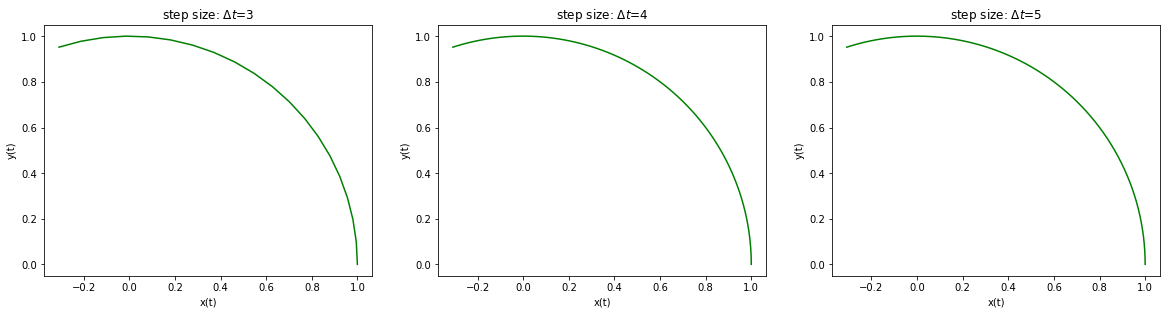

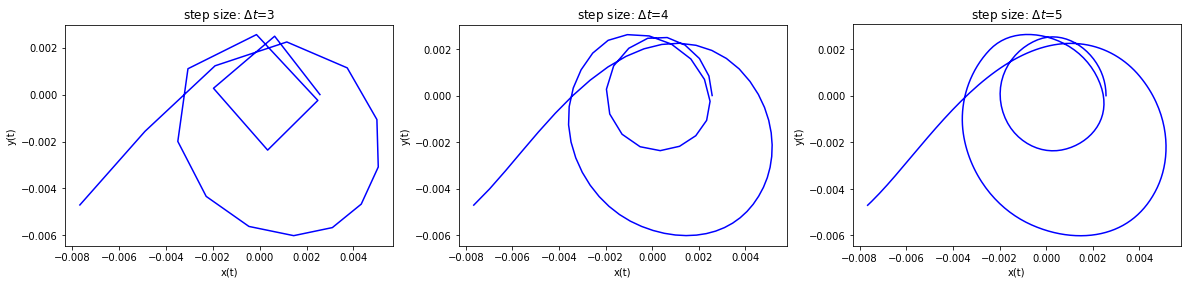

In [7]:
plot_trajectories(trajectories)

In [8]:
def plot_energy(plot_info):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    
    energy = plot_info[2]['energy'] - plot_info[2]['energy'][0]
    angular = plot_info[2]['angular'] - plot_info[2]['angular'][0]
    t = plot_info[2]['time']
    
    axs[0].plot(t, energy)
    axs[0].set_title('Total energy deviation: $H(t)-H(0)$')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('$H(t)-H(0)$')

    axs[1].plot(t, angular)
    axs[1].set_title('Total angular momentum deviation: $L(t)-L(0)$')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('$L(t)-L(0)$')

    plt.show()

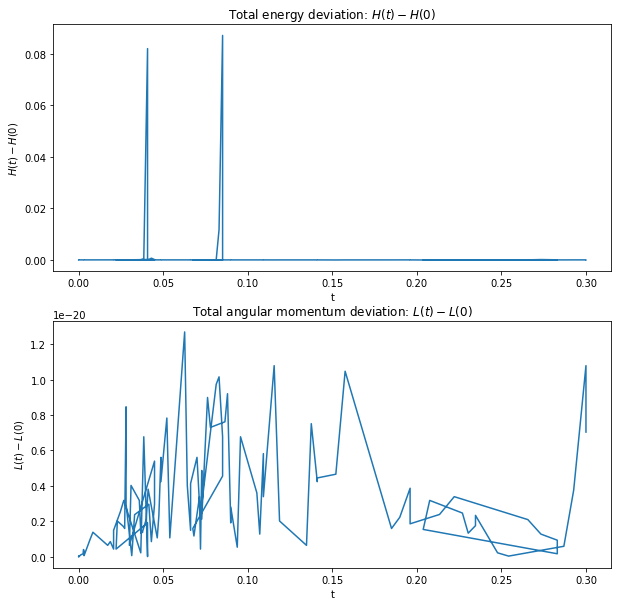

In [9]:
plot_energy(plot_info)

In [109]:
n_verlet = 10
t_span = [0, 0.3] #yr
trajectories_verlet = []
plot_info_verlet = []
tb_verlet = ThreeBody()
solution_verlet = tb_verlet.velocity_verlet(n_verlet, t_span)

traj_verlet = tb_verlet.verlet_trajectories()

trajectories_verlet.append({'sun': traj_verlet[0],
                    'earth': traj_verlet[1],
                    'moon': traj_verlet[2],
                    'n': n_verlet})
info_verlet = tb_verlet.plot_info()
plot_info_verlet.append({'energy': info_verlet[0],
                'angular': info_verlet[1],
                'time': info_verlet[2],
                'n': n_verlet})

314573


In [110]:
print(trajectories_verlet[0])

{'sun': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'earth': array([[ 0.00000000e+00,  6.28318531e+00],
       [-1.12317642e-10,  6.28318531e+00],
       [-2.24635283e-10,  6.28318531e+00],
       ...,
       [-1.66435101e-05,  6.28317530e+00],
       [-1.66435217e-05,  6.28317530e+00],
       [-1.66435334e-05,  6.28317530e+00]]), 'moon': array([[ 0.00000000e+00,  6.49925807e+00],
       [-2.01317229e-12,  6.49925807e+00],
       [-4.02634458e-12,  6.49925807e+00],
       ...,
       [-2.06686011e-07,  6.49925794e+00],
       [-2.06686143e-07,  6.49925794e+00],
       [-2.06686275e-07,  6.49925794e+00]]), 'n': 10}


In [106]:
def plot_verlet(trajectories_verlet):
    earth_x = trajectories_verlet[0]['earth'][:,0]
    earth_y = trajectories_verlet[0]['earth'][:,1]
    moon_x = trajectories_verlet[0]['moon'][:,0] 
    moon_y = trajectories_verlet[0]['moon'][:,1] - earth_y

    print(moon_x)
    print(moon_x - earth_x)
    
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs[0].plot(earth_x, earth_y)
    axs[0].set_title('Parametric orbit of Earth with verlet:{0}'.format(n_verlet))
    axs[0].set_xlabel('x(t)')
    axs[0].set_ylabel('y(t)')

    axs[1].plot(moon_x, moon_y)
    axs[1].set_title('Parametric orbit of Moon with verlet:{0}'.format(n_verlet))
    axs[1].set_xlabel('x(t)')
    axs[1].set_ylabel('y(t)')
    plt.show()

[ 0.00000000e+00 -2.87911772e-08 -5.19828510e-08 -7.28698666e-08
 -9.19125073e-08 -1.09017233e-07 -1.24150243e-07 -1.37379556e-07
 -1.48847140e-07 -1.58734639e-07 -1.67236216e-07 -1.74540678e-07
 -1.80821481e-07 -1.86232310e-07 -1.90906162e-07 -1.94956383e-07
 -1.98478647e-07 -2.01553243e-07 -2.04247356e-07 -2.06617152e-07]
[0.00000000e+00 1.80222393e-06 3.56394310e-06 5.23371360e-06
 6.77747085e-06 8.17581618e-06 9.42185421e-06 1.05184332e-05
 1.14749604e-05 1.23045116e-05 1.30216090e-05 1.36407258e-05
 1.41754046e-05 1.46378220e-05 1.50386452e-05 1.53870600e-05
 1.56908895e-05 1.59567499e-05 1.61902153e-05 1.63959727e-05]


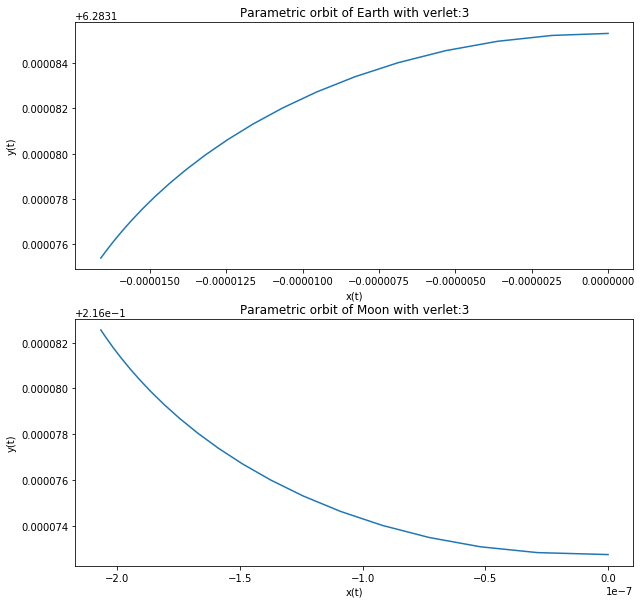

In [107]:
plot_verlet(trajectories_verlet)